In [1]:
import sys
# Add ../src to the system path
sys.path.append("../src")

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaConfig, BitsAndBytesConfig
from transformers.models.llama.modeling_llama import LlamaRotaryEmbedding

from models.modeling_table_llama import TableLlamaForCausalLM, TableLlamaConfig, TableLlamaRotaryEmbedding

In [2]:
MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct" 

# Testing for TableLlamaRotaryEmbedding

In this test case, we set the rope_table_llama to:
* channel_period = 10000002
* x_channel_offset = 10000000
* y_channel_offset = 10000001
* line_length = 32

Since offsets are larger than the channel dim in the Llama model, no channel will be altered and the results should be the same as the original Llama model.


In [3]:
llama_config = LlamaConfig.from_pretrained(MODEL_NAME)
table_llama_config = TableLlamaConfig.from_pretrained(MODEL_NAME)

table_llama_config.rope_table_llama = {
    "x_channels_start": 0,
    "x_channels_end": 1,
    "x_channels_step": 1,
    "y_channels_start": None,
    "y_channels_end": None,
    "y_channels_step": None,
    "line_length": 32
}

llama_rotary_embedding = LlamaRotaryEmbedding(config=llama_config)
table_llama_rotary_embedding = TableLlamaRotaryEmbedding(table_llama_config)

In [8]:
# Setting up the input
seq_start = 0
seq_len = 1500
batch_size = 3
head_dim = 64

x = torch.randn(batch_size, seq_len, head_dim)
position_ids = torch.arange(seq_start, seq_start + seq_len).repeat(batch_size,1).to(x.device)

llama_cos, llama_sin = llama_rotary_embedding(x, position_ids)
table_llama_cos, table_llama_sin = table_llama_rotary_embedding(x, position_ids)

print(torch.allclose(llama_cos, table_llama_cos)) # Should be True
print(torch.allclose(llama_sin[:,:,0:32], table_llama_sin[:,:,0:32])) # Should be True



False
False


# Testing the entire model
The settings for the model are the same as the testing for TableLlamaRotaryEmbedding. So the two models should give the same results.


In [9]:
bnb_config = BitsAndBytesConfig(load_in_8bit=True)

# Clear the cache
if "llama_model" in globals():
    del llama_model
if "table_llama_model" in globals():
    del table_llama_model
    
torch.cuda.empty_cache()

llama_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, 
    quantization_config=bnb_config, 
    device_map="auto",
    config=llama_config
)
table_llama_model = TableLlamaForCausalLM.from_pretrained(
    MODEL_NAME, 
    quantization_config=bnb_config, 
    device_map="auto",
    config=table_llama_config
)


In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"

messages = [
    [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Hello, how are you?"},
    ],
    [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "What is the weather in Stanford?"},
    ],
    [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Why is the sky blue?"},
    ]
]
texts = [tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True) for messages in messages]
tokenized_inputs = tokenizer(texts, return_tensors="pt", add_special_tokens=False, padding=True, truncation=True).to(table_llama_model.device)

In [12]:
table_llama_outputs = table_llama_model.generate(**tokenized_inputs, max_new_tokens=50, do_sample=False)
llama_outputs = llama_model.generate(**tokenized_inputs, max_new_tokens=50, do_sample=False)

for i in range(len(messages)):
    table_llama_output = tokenizer.decode(table_llama_outputs[i, len(tokenized_inputs.input_ids[i]):], skip_special_tokens=True).replace("\n", " ")
    llama_output = tokenizer.decode(llama_outputs[i, len(tokenized_inputs.input_ids[i]):], skip_special_tokens=True).replace("\n", " ")
    print("-"*100)
    if table_llama_output == llama_output:
        print(f"Message {i+1} is the same") # Should be True
    else:
        print(f"Message {i+1} is different")

    print(f"TableLlama: {table_llama_output}")
    print(f"     Llama: {llama_output}")
    


/home/yuchi/mambaforge/envs/cs230/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/yuchi/mambaforge/envs/cs230/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


----------------------------------------------------------------------------------------------------
Message 1 is different
TableLlama: I'm doing well, thank you for asking. It's great to connect with you. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm here to assist you with any questions or topics you
     Llama: I'm doing well, thanks for asking. It's great to connect with you. Is there anything on your mind that you'd like to chat about, or are you just looking for some general information or assistance? I'm here to help!
----------------------------------------------------------------------------------------------------
Message 2 is different
TableLlama: I'm happy to help you with the weather in Stanford, California. However, I need a bit more information from you. Stanford is a city located in the San Francisco Bay Area, and its weather can vary depending on the time of year and the
     Llama: I'm not aware of the current weather conditi

# Testing the similarity between the two positions

In [13]:
import matplotlib.pyplot as plt
import numpy as np
def similarity(q):
    """
    q: [seq_len, head_dim]
    return: [seq_len, seq_len]
    Calculate the cosine similarity between all pairs of positions in q.
    """
    q = q / torch.norm(q, dim=-1, keepdim=True)
    sim = q @ q.T
    return sim

def plot_similarity(similarity_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_matrix, cmap='viridis', origin='lower')
    plt.colorbar(label='Similarity')
    plt.title('Cosine Similarity Matrix')
    plt.show()
    
def plot_spatial_similarity(m, w, h, similarity_matrix, line_length):
    plt.figure(figsize=(8, 6))

    map = np.zeros((h,w))
    center = m + w//2 + h//2*line_length
    for j in range(h):
        for i in range(w):
            realpos = m + j*line_length + i
            val = similarity_matrix[center,realpos]
            map[h-j-1,i] = val
            num_str = f'{val:.2f}'
            # Remove the 0 before the decimal point
            num_str = num_str.lstrip('0')
            plt.text(i, h-j-1, num_str, ha='center', va='center', color="black")

    # Set the range from 0 to 1
    plt.imshow(map, cmap='viridis', origin='lower', vmax=1, vmin=0)
    # Set x ticks and y ticks
    plt.xticks(np.arange(0, w, 1), np.arange(0, w, 1)-w//2)
    plt.yticks(np.arange(0, h, 1), np.arange(h, 0, -1)-h//2-1)
    plt.colorbar(label='Similarity')
    plt.show()


We first reset the config.

In [37]:
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb

# Reset the config
table_llama_config = TableLlamaConfig.from_pretrained(MODEL_NAME)
llama_config = LlamaConfig.from_pretrained(MODEL_NAME)

table_llama_config.rope_table_llama = {
    "x_channels_start": 0,
    "x_channels_end": 6,
    "x_channels_step": 2,
    "y_channels_start": None,
    "y_channels_end": None,
    "y_channels_step": None,
    "line_length": 32
}

# Setting up the input
seq_start = 0
seq_len = 512
batch_size = 3
head_dim = table_llama_config.hidden_size // table_llama_config.num_attention_heads
head_num = table_llama_config.num_attention_heads


table_llama_rotary_embedding = TableLlamaRotaryEmbedding(table_llama_config)
llama_rotary_embedding = LlamaRotaryEmbedding(config=llama_config)


q = torch.ones(batch_size, head_num, seq_len, head_dim) # [batch_size, heads, seq_len, head_dim]
k = torch.ones(batch_size, head_num, seq_len, head_dim) # [batch_size, heads, seq_len, head_dim]

position_ids = torch.arange(seq_start, seq_start + seq_len).repeat(batch_size,1).to(q.device)

table_llama_cos, table_llama_sin = table_llama_rotary_embedding(q, position_ids)
llama_cos, llama_sin = llama_rotary_embedding(q, position_ids)


# use the `apply_rotary_pos_emb` function to get the new x.
table_llama_q, table_llama_k = apply_rotary_pos_emb(q, k, table_llama_cos, table_llama_sin) # [batch_size, heads, seq_len, head_dim]
llama_q, llama_k = apply_rotary_pos_emb(q, k, llama_cos, llama_sin) # [batch_size, heads, seq_len, head_dim]


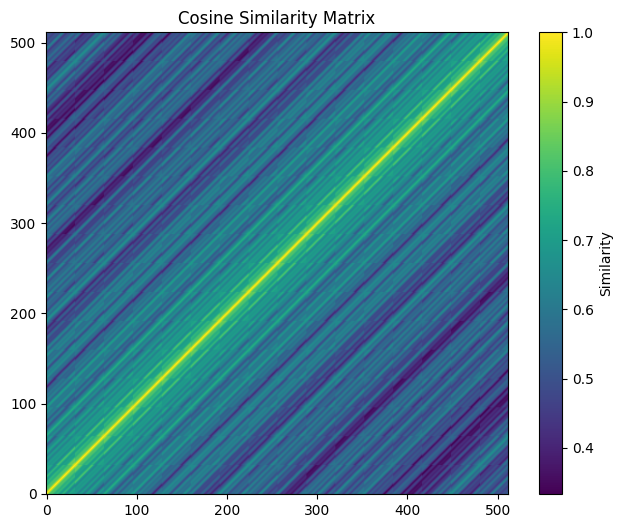

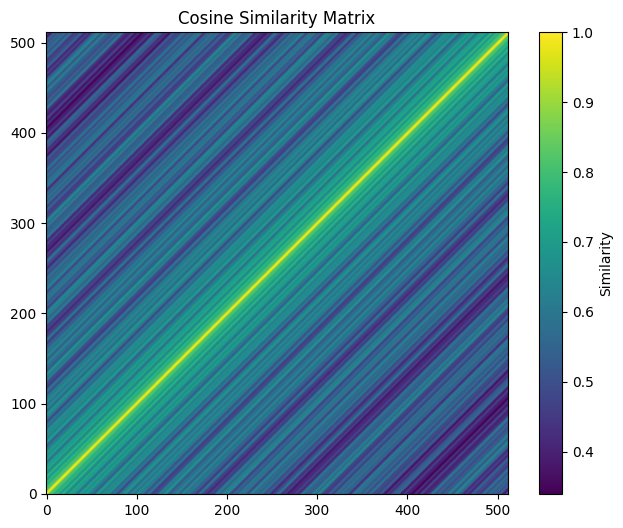

In [38]:
# Take batch 0, head 0 for comparison

table_llama_similarity = similarity(table_llama_q[0,0,:,:]) 
llama_similarity = similarity(llama_q[0,0,:,:])

plot_similarity(table_llama_similarity)
plot_similarity(llama_similarity)


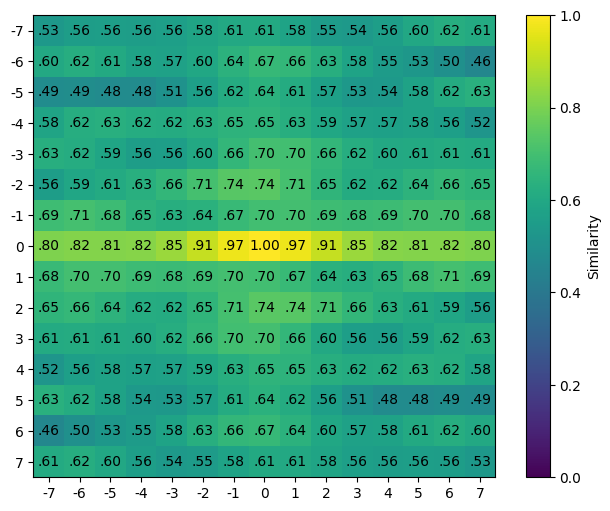

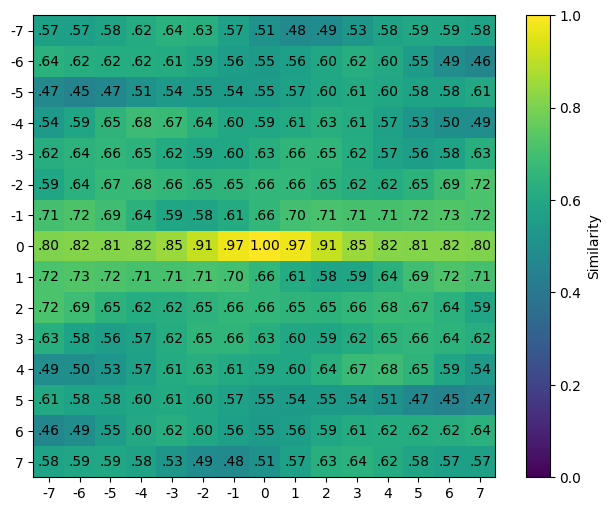

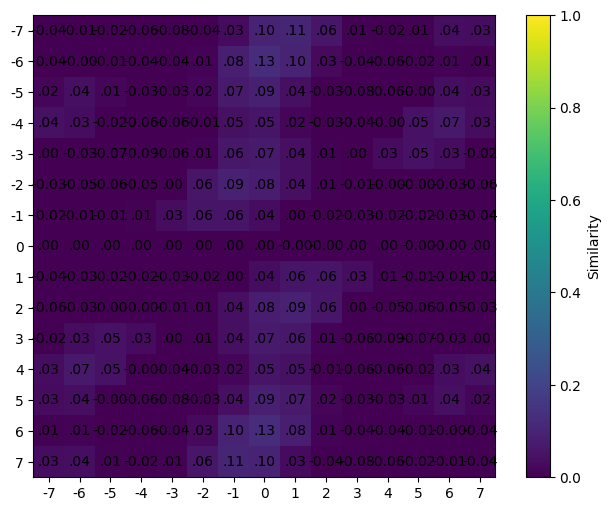

In [39]:
plot_spatial_similarity(0, 15, 15, table_llama_similarity, table_llama_config.rope_table_llama["line_length"])
plot_spatial_similarity(0, 15, 15, llama_similarity, table_llama_config.rope_table_llama["line_length"])
plot_spatial_similarity(0, 15, 15, table_llama_similarity - llama_similarity, table_llama_config.rope_table_llama["line_length"])


